In [213]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
from typing import List
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from tqdm import tqdm
import matplotlib as mpl
import seaborn as sns
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.ticker import FuncFormatter
from itertools import product as pp
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
mpl.rcParams["figure.dpi"] = 480
mpl.rcParams["figure.figsize"] = (10, 6)
plt.style.use("ggplot")
rng = np.random.default_rng()

In [214]:
current_working_directory = os.getcwd()
year = "2019"
bin_sample_path = f"{current_working_directory}/binSamples/"
fill_sample_path = f"{current_working_directory}/fillSamples/"
result_path = f"{current_working_directory}/Results/"

In [27]:
flist =[]
for month_int in tqdm(range(1,13)):
    month ='%02d'% month_int
    filename ="bin%s%s.csv"%(year,month)
    df = pd.read_csv(bin_sample_path + filename)
    flist.append(df)

df_out = pd.concat(flist,axis=0,ignore_index=False)
df_out.to_csv(f"{result_path}inter_results_pre_{year}all.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:27<00:00,  2.32s/it]


# 2.4. Synthetic alphas
Implement synthetic lookahead alphas for the alpha level and decay.


In [215]:
def impact_resultant_prices(trades, prices, decay, impact_coef, model, price_vol, ADV):
    model_space = {"OW": "linear", "Bouchaud": "sqrt"}
    space_kernels = {
        "linear" : lambda x : x,
        "sqrt" : lambda x : np.sign(x) * np.sqrt(np.abs(x)),
    }
    trades_copy = trades.copy()
    trades_copy = space_kernels[model_space[model]](trades_copy)
    trades_copy[1:] /= (1 - decay)
    trades_copy *= price_vol / space_kernels[model_space[model]](ADV)
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean()
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)

In [216]:
def regression_result(daily_stock_reg_info_df: pd.DataFrame, in_sample_month: int) -> pd.DataFrame:
    """
    daily_stock_reg_info_df: columns.name = ["stock", "date", "x", "y", "xy", "x2", "y2", "count"]
    """
    daily_stock_reg_info_df['date']=pd.to_datetime(daily_stock_reg_info_df['date'])
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]
    in_sample_summary_df = in_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()

    summary_df = in_sample_summary_df.copy()
    out_sample_summary_df = out_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()
    in_sample_summary_df.columns = "is_" + in_sample_summary_df.columns
    out_sample_summary_df.columns = "oos_" + out_sample_summary_df.columns

    summary_df = pd.merge(in_sample_summary_df, out_sample_summary_df, left_index=True, right_index=True, how="inner")

    summary_df["beta_estimate"] = (summary_df["is_xy"] - summary_df["is_x"] * summary_df["is_y"] / summary_df["is_count"]) / (summary_df["is_x2"] - summary_df["is_x"] ** 2 / summary_df["is_count"])
    summary_df["alpha_estimate"] = summary_df["is_y"] / summary_df["is_count"] - summary_df["beta_estimate"] * summary_df["is_x"] / summary_df["is_count"]
    summary_df["is_sst"] = summary_df["is_y2"] - summary_df["is_y"] ** 2 / summary_df["is_count"]
    summary_df["is_ssr"]  = summary_df["is_y2"] - 2 * summary_df["alpha_estimate"] * summary_df["is_y"] - 2 * summary_df["beta_estimate"] * summary_df["is_xy"] + summary_df["is_count"] * summary_df["alpha_estimate"] ** 2 + 2 * summary_df["beta_estimate"] * summary_df["alpha_estimate"] * summary_df["is_x"] + summary_df["is_x2"] * summary_df["beta_estimate"] ** 2
    summary_df["is_rsq"] = 1 - summary_df["is_ssr"] / summary_df["is_sst"]
    
    summary_df["oos_sst"] = summary_df["oos_y2"] - summary_df["oos_y"] ** 2 / summary_df["oos_count"]
    summary_df["oos_ssr"]  = summary_df["oos_y2"] - 2 * summary_df["alpha_estimate"] * summary_df["oos_y"] - 2 * summary_df["beta_estimate"] * summary_df["oos_xy"] + summary_df["oos_count"] * summary_df["alpha_estimate"] ** 2 + 2 * summary_df["beta_estimate"] * summary_df["alpha_estimate"] * summary_df["oos_x"] + summary_df["oos_x2"] * summary_df["beta_estimate"] ** 2
    summary_df["oos_rsq"] = 1 - summary_df["oos_ssr"] / summary_df["oos_sst"]
    return summary_df

In [217]:
num_days_precompute = 20
filename = f"inter_results_pre_{year}all.csv"
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol": stacked_info["px_vol"].unstack(),
    "volume": stacked_info["volume"].unstack(),
}).reset_index()

asset = "AAPL"
dates = "2019-03-14"

ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
price_vol = ssdf["px_vol"]
ADV = ssdf["volume"]
decay = np.exp(-np.log(2) / 3600 * 10)

month = dates.split("-")[1]
in_sample = int(month) - 1

filename = f"inter_results_px_{2019}{month}.csv"
px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
filename = f"inter_results_volume_{2019}{month}.csv"
volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
prices = px_df.loc[(asset,dates)]
trades = volumes.loc[(asset,dates)]

In [218]:
filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
test_OW = pd.read_csv(result_path+filename)
res_ow = regression_result(test_OW, in_sample)
res_ow = res_ow.loc[asset]

## 2.4.1. Baseline: implements the same synthetic alpha as in the homework

Create synthetic alphas: On the binned sample data, we define the forward return $r$ and synthetic alpha $\alpha$ as such
$$
\begin{aligned}
r_t^h & =\frac{P_{t+h}-P_t}{P_t} \\
\alpha_t^h & =\frac{x \cdot\left(P_{t+h}-P_t\right)+y \cdot\left(W_{t+h}-W_t\right)}{P_t}=x r_t^h+\frac{y \cdot\left(W_{t+h}-W_t\right)}{P_t}
\end{aligned}
$$
where $W$ is a simulated standard Brownian motion, and $h$ is the time horizon of computed returns.

Here we use impact-adjusted prices to calculate synthetic alphas.

In [219]:
def synthetic_alpha_generator(rho: float, prices: pd.DataFrame, horizon: int):
    """
    rho: correlation
    horizon: number of 10 seconds
    prices: impact-adjusted prices
    """
    x = rho ** 2
    returns = prices.pct_change(horizon)
    var = returns.var()
    p_minus2 = 1/(prices**2)
    p_minus_mean = p_minus2.mean()
    h = horizon
    y = rho * np.sqrt(1-rho**2)*np.sqrt(var/(h*p_minus_mean))
    normal = rng.normal(loc = 0, scale = h, size = prices.shape)
    res = x * returns + y * normal / prices
    
    return res.fillna(0),returns

In [220]:
def synthetic_alpha(rho, asset, dates, horizon = 1):
    """
    rho: correlation
    asset: name of stock
    dates: date of trade
    """
    ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
    price_vol = ssdf["px_vol"]
    ADV = ssdf["volume"]
    decay = np.exp(-np.log(2) / 3600 * 10)

    month = dates.split("-")[1]
    in_sample = int(month) - 1

    filename = f"inter_results_px_{2019}{month}.csv"
    px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
    filename = f"inter_results_volume_{2019}{month}.csv"
    volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
    prices = px_df.loc[(asset,dates)]
    trades = volumes.loc[(asset,dates)]
    filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
    test_OW = pd.read_csv(result_path+filename)
    res_ow = regression_result(test_OW, in_sample)
    res_ow = res_ow.loc[asset]

    S = impact_resultant_prices(trades, prices, decay, res_ow["beta_estimate"], "OW", price_vol.values, ADV.values)
    alpha,returns = synthetic_alpha_generator(rho, S, horizon)

    return alpha,returns

In [222]:
def smooth_alpha(alpha, time_unit = 10):
    smoothed = alpha.ewm(halflife=200).mean()
    deriv_1 = smoothed.diff(1).shift(-1).fillna(0) / time_unit
    deriv_2 = smoothed.diff(1).diff(1).shift(-1).fillna(0) / (time_unit ** 2)
    return smoothed[200:], deriv_1[200:], deriv_2[200:]

In [230]:
asset = "AAPL"
dates = "2019-03-14"
rho = 0.7
alpha,returns = synthetic_alpha(rho, asset, dates)
alpha = alpha.cumsum()
returns = returns.cumsum()

smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)

C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4748496.00680968  -3336008.19747074   -763169.71075067 ...
   4737578.72893109 -36989297.06377441         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay)
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_returns = prices / prices[0] - 1
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\3925454060.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(prices[200:].index), smoothed.values, label="Smoothed Synthetic alpha")
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\3925454060.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(prices[200:].index), returns[200:].values, label="Forward return")
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\3925454060.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(prices[200:].index), 

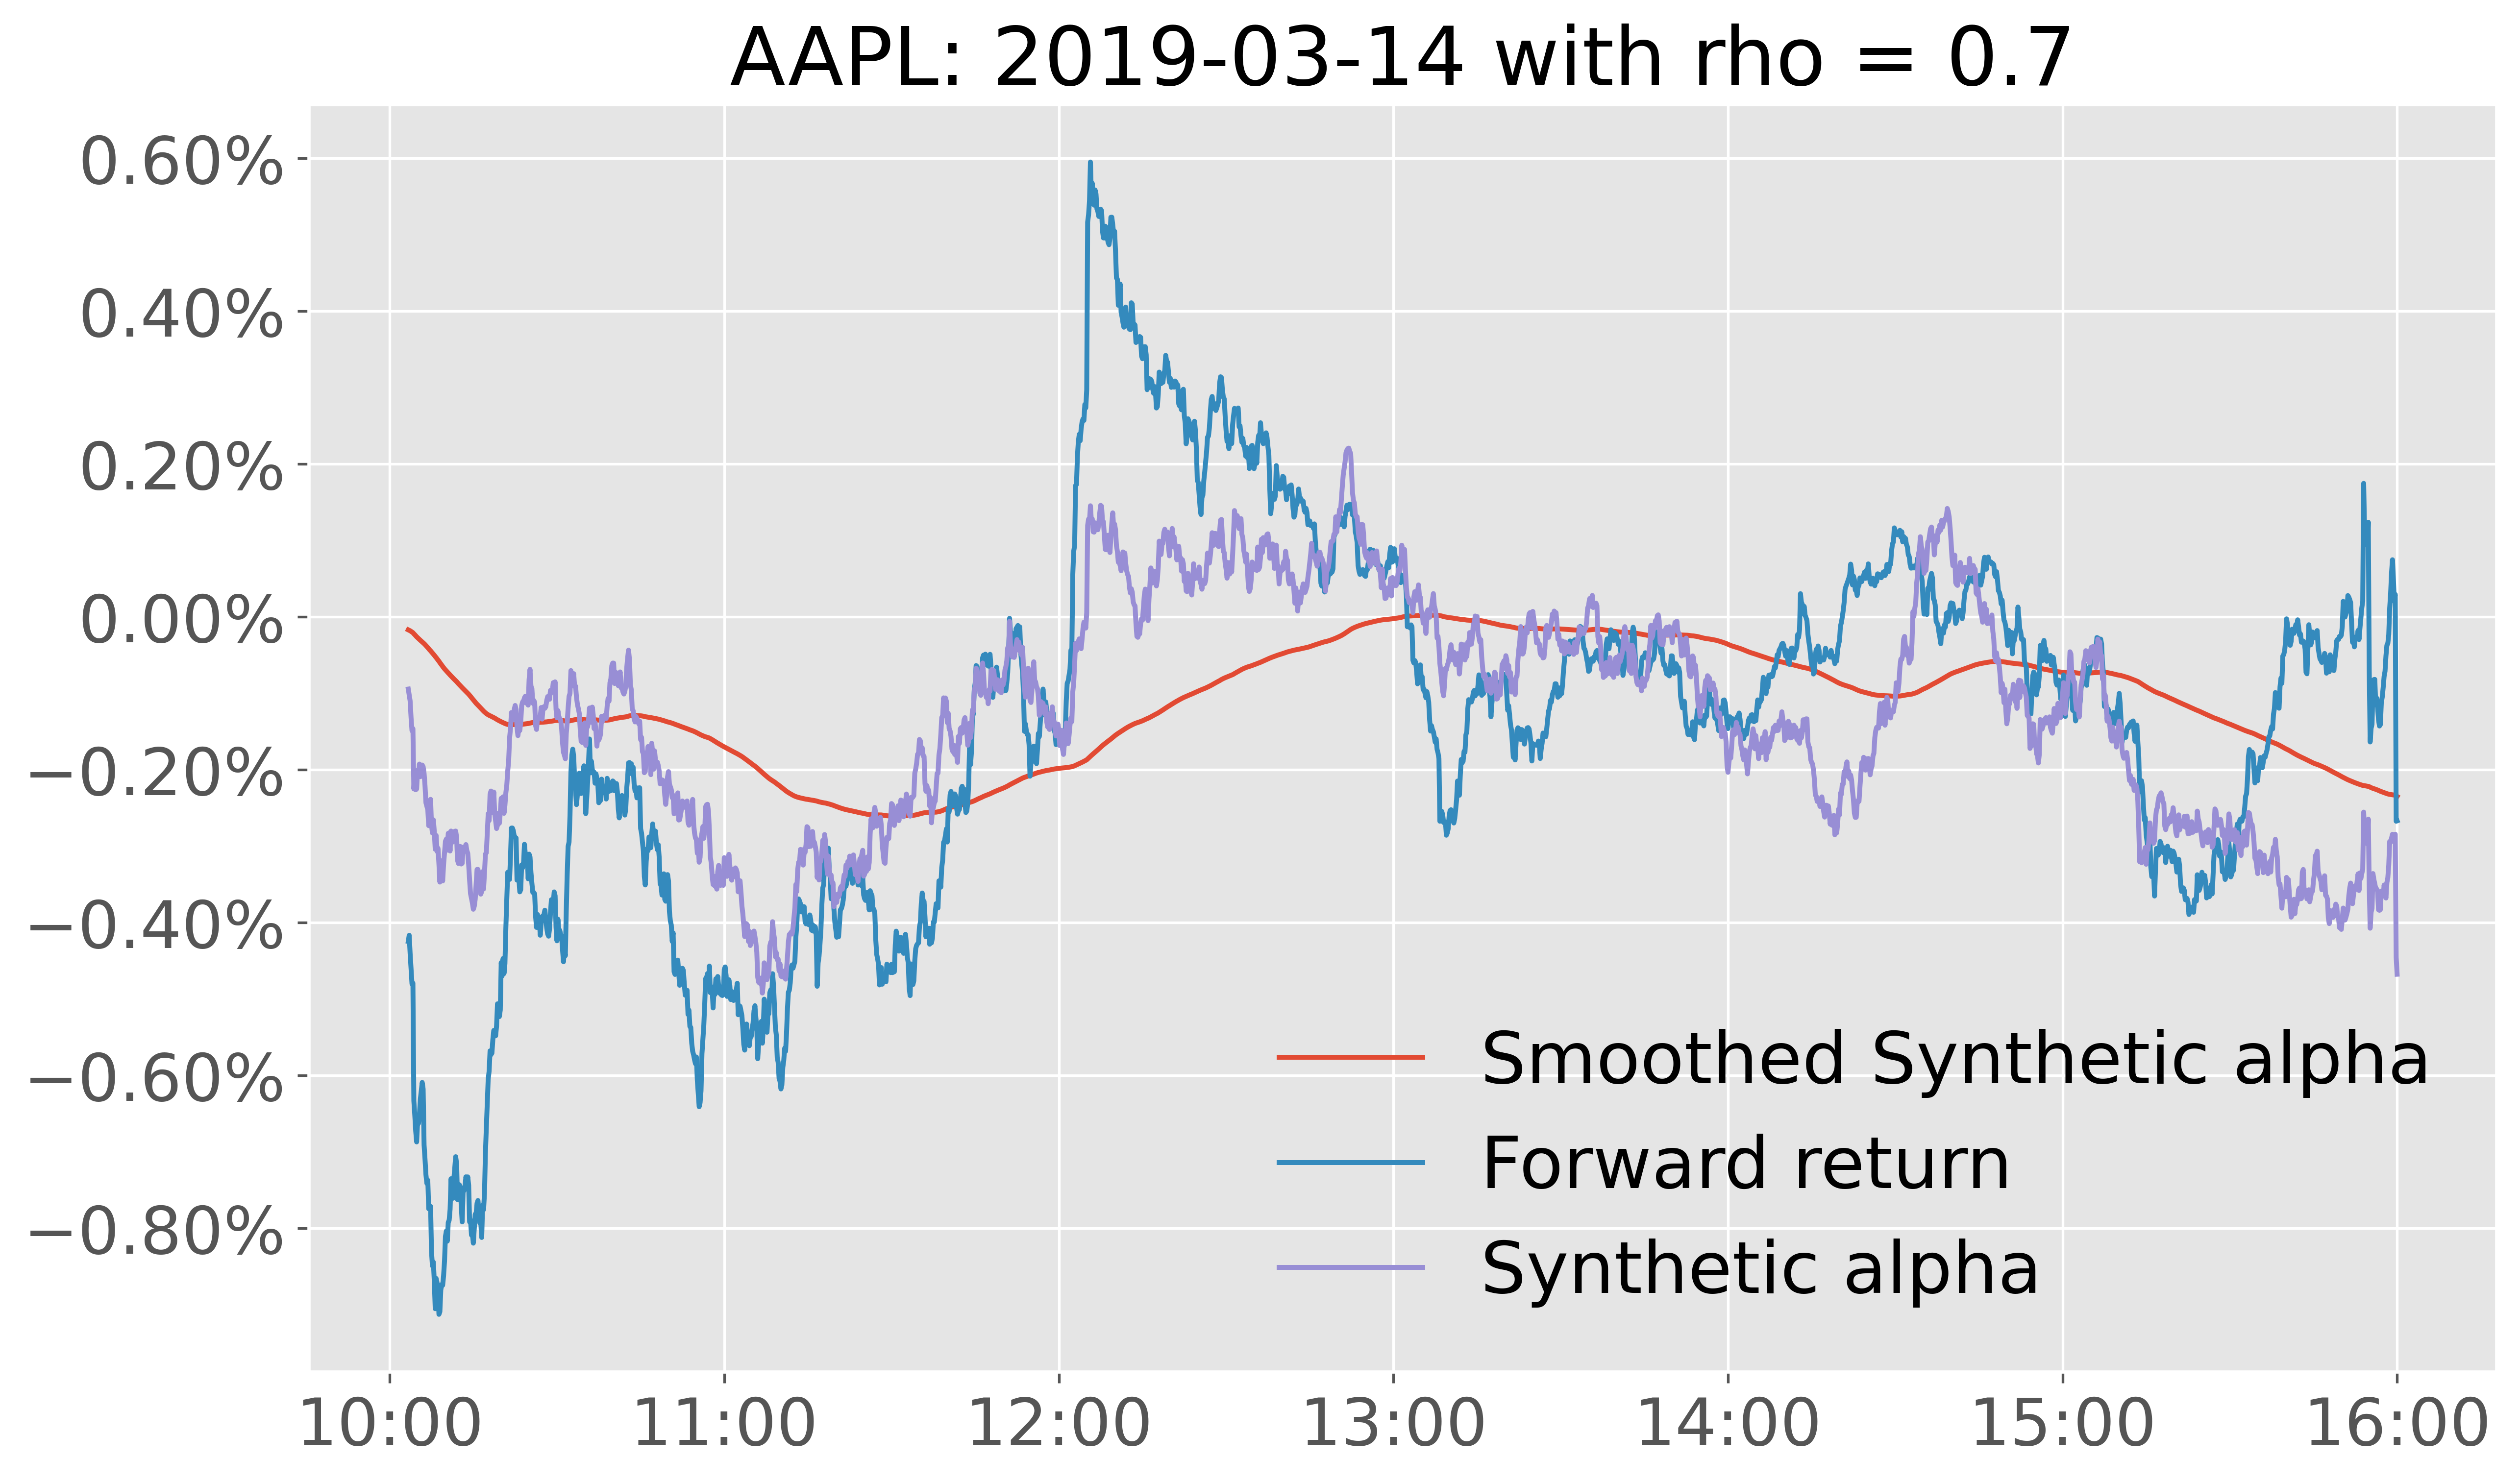

In [231]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(pd.to_datetime(prices[200:].index), smoothed.values, label="Smoothed Synthetic alpha")
ax.plot(pd.to_datetime(prices[200:].index), returns[200:].values, label="Forward return")
ax.plot(pd.to_datetime(prices[200:].index), alpha[200:].values, label="Synthetic alpha")
ax.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title(f"{asset}: {dates} with rho = {rho}", fontsize=25)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
ax.legend(fontsize=22, frameon=False)
plt.savefig('smth_syn_alpha.eps', format='eps')
plt.show()

## 2.4.2 Expand: implement an additional synthetic alpha for the overnight return

Use similar method as 2.4.1, we define the forward overnight return $r$ and synthetic alpha $\alpha$ as such
$$
\begin{aligned}
r_t^h & =\frac{P_{t+h}-P_t}{P_t} \\
\alpha_t^h & =\frac{x \cdot\left(P_{t+h}-P_t\right)+y \cdot\left(W_{t+h}-W_t\right)}{P_t}=x r_t^h+\frac{y \cdot\left(W_{t+h}-W_t\right)}{P_t}
\end{aligned}
$$
where $W$ is a simulated standard Brownian motion, and $h$ means the number of days.

Calculate overnight return:

In [106]:
flist =[]
for month_int in tqdm(range(1,13)):
    month ='%02d'% month_int
    filename ="fills%s%s.csv"%(year,month)
    fill_sample_df = pd.read_csv(fill_sample_path + filename)[["stock", "date", "trade", "time", "mid"]].fillna(0)
    fill_sample_df['date'] = pd.to_datetime(fill_sample_df['date'])
    fill_sample_df['time'] = pd.to_datetime(fill_sample_df['time'], format='%H:%M:%S.%f').dt.time
    
    # Get the closing price for each day (last trade of the day)
    closing_prices = fill_sample_df.groupby('date').apply(lambda x: x.loc[x['time'] == max(x['time']), 'mid']).reset_index(level=1, drop=True)
    closing_prices.name = 'close'
    
    # Get the opening price for each day (first trade of the day)
    opening_prices = fill_sample_df.groupby('date').apply(lambda x: x.loc[x['time'] == min(x['time']), 'mid']).reset_index(level=1, drop=True)
    opening_prices.name = 'open'

    # Get the opening price for each day (first trade of the day)
    volume = fill_sample_df.groupby('date')['trade'].sum()
    volume.name = 'volume'

    # Reset index to ensure there are no duplicate labels
    closing_prices = closing_prices.reset_index()
    opening_prices = opening_prices.reset_index()
    volume = volume.reset_index()
    
    # Merge closing and opening prices into a single dataframe
    price_df = pd.merge(closing_prices, opening_prices, on='date')
    price_df = pd.merge(price_df, volume, on='date')
    
    # Select only the required columns
    df = price_df[['date', 'open', 'close','volume']]
    
    flist.append(df)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:28<00:00,  2.36s/it]


In [232]:
overnight_return_df = pd.concat(flist,axis=0,ignore_index=False).reset_index()

overnight_return_df

,index,date,open,close,volume
0,0,2019-01-02,154.770,157.920,57523
1,1,2019-01-03,143.965,142.085,465296
2,2,2019-01-04,144.575,148.255,1975091
3,3,2019-01-07,148.675,147.860,-585832
4,4,2019-01-08,149.405,150.765,52456
...,...,...,...,...,...
263,15,2019-12-23,280.495,283.975,518701
264,16,2019-12-24,284.530,284.275,42676
265,17,2019-12-26,284.790,289.920,110550
266,18,2019-12-26,284.790,289.910,110550


$$
\begin{aligned}
& x=\rho^2 \\
& y=\rho \sqrt{1-\rho^2} \sqrt{\frac{\operatorname{Var}\left(r_t^h\right)}{\mathbb{E}\left[\frac{1}{P_t^2}\right] h}}
\end{aligned}
$$

In [233]:
def synthetic_overnight_alpha_generator(rho: float, overnight_return_df: pd.DataFrame, horizon: int):
    """
    rho: correlation
    horizon: number of days
    prices: unperturbed prices
    """
    x = rho ** 2
    h = horizon
    returns = (overnight_return_df['open'] - overnight_return_df['close'].shift(h)) / overnight_return_df['close'].shift(h)
    var = returns.var()
    p_minus2 = 1/((overnight_return_df['close'].shift(h))**2)
    p_minus_mean = p_minus2.mean()
    y = rho * np.sqrt(1-rho**2)*np.sqrt(var/(h*p_minus_mean))
    normal = rng.normal(loc = 0, scale = h, size = overnight_return_df['open'].shape)
    res = x * returns + y * normal / (overnight_return_df['close'].shift(h))
    
    return res.fillna(0), returns

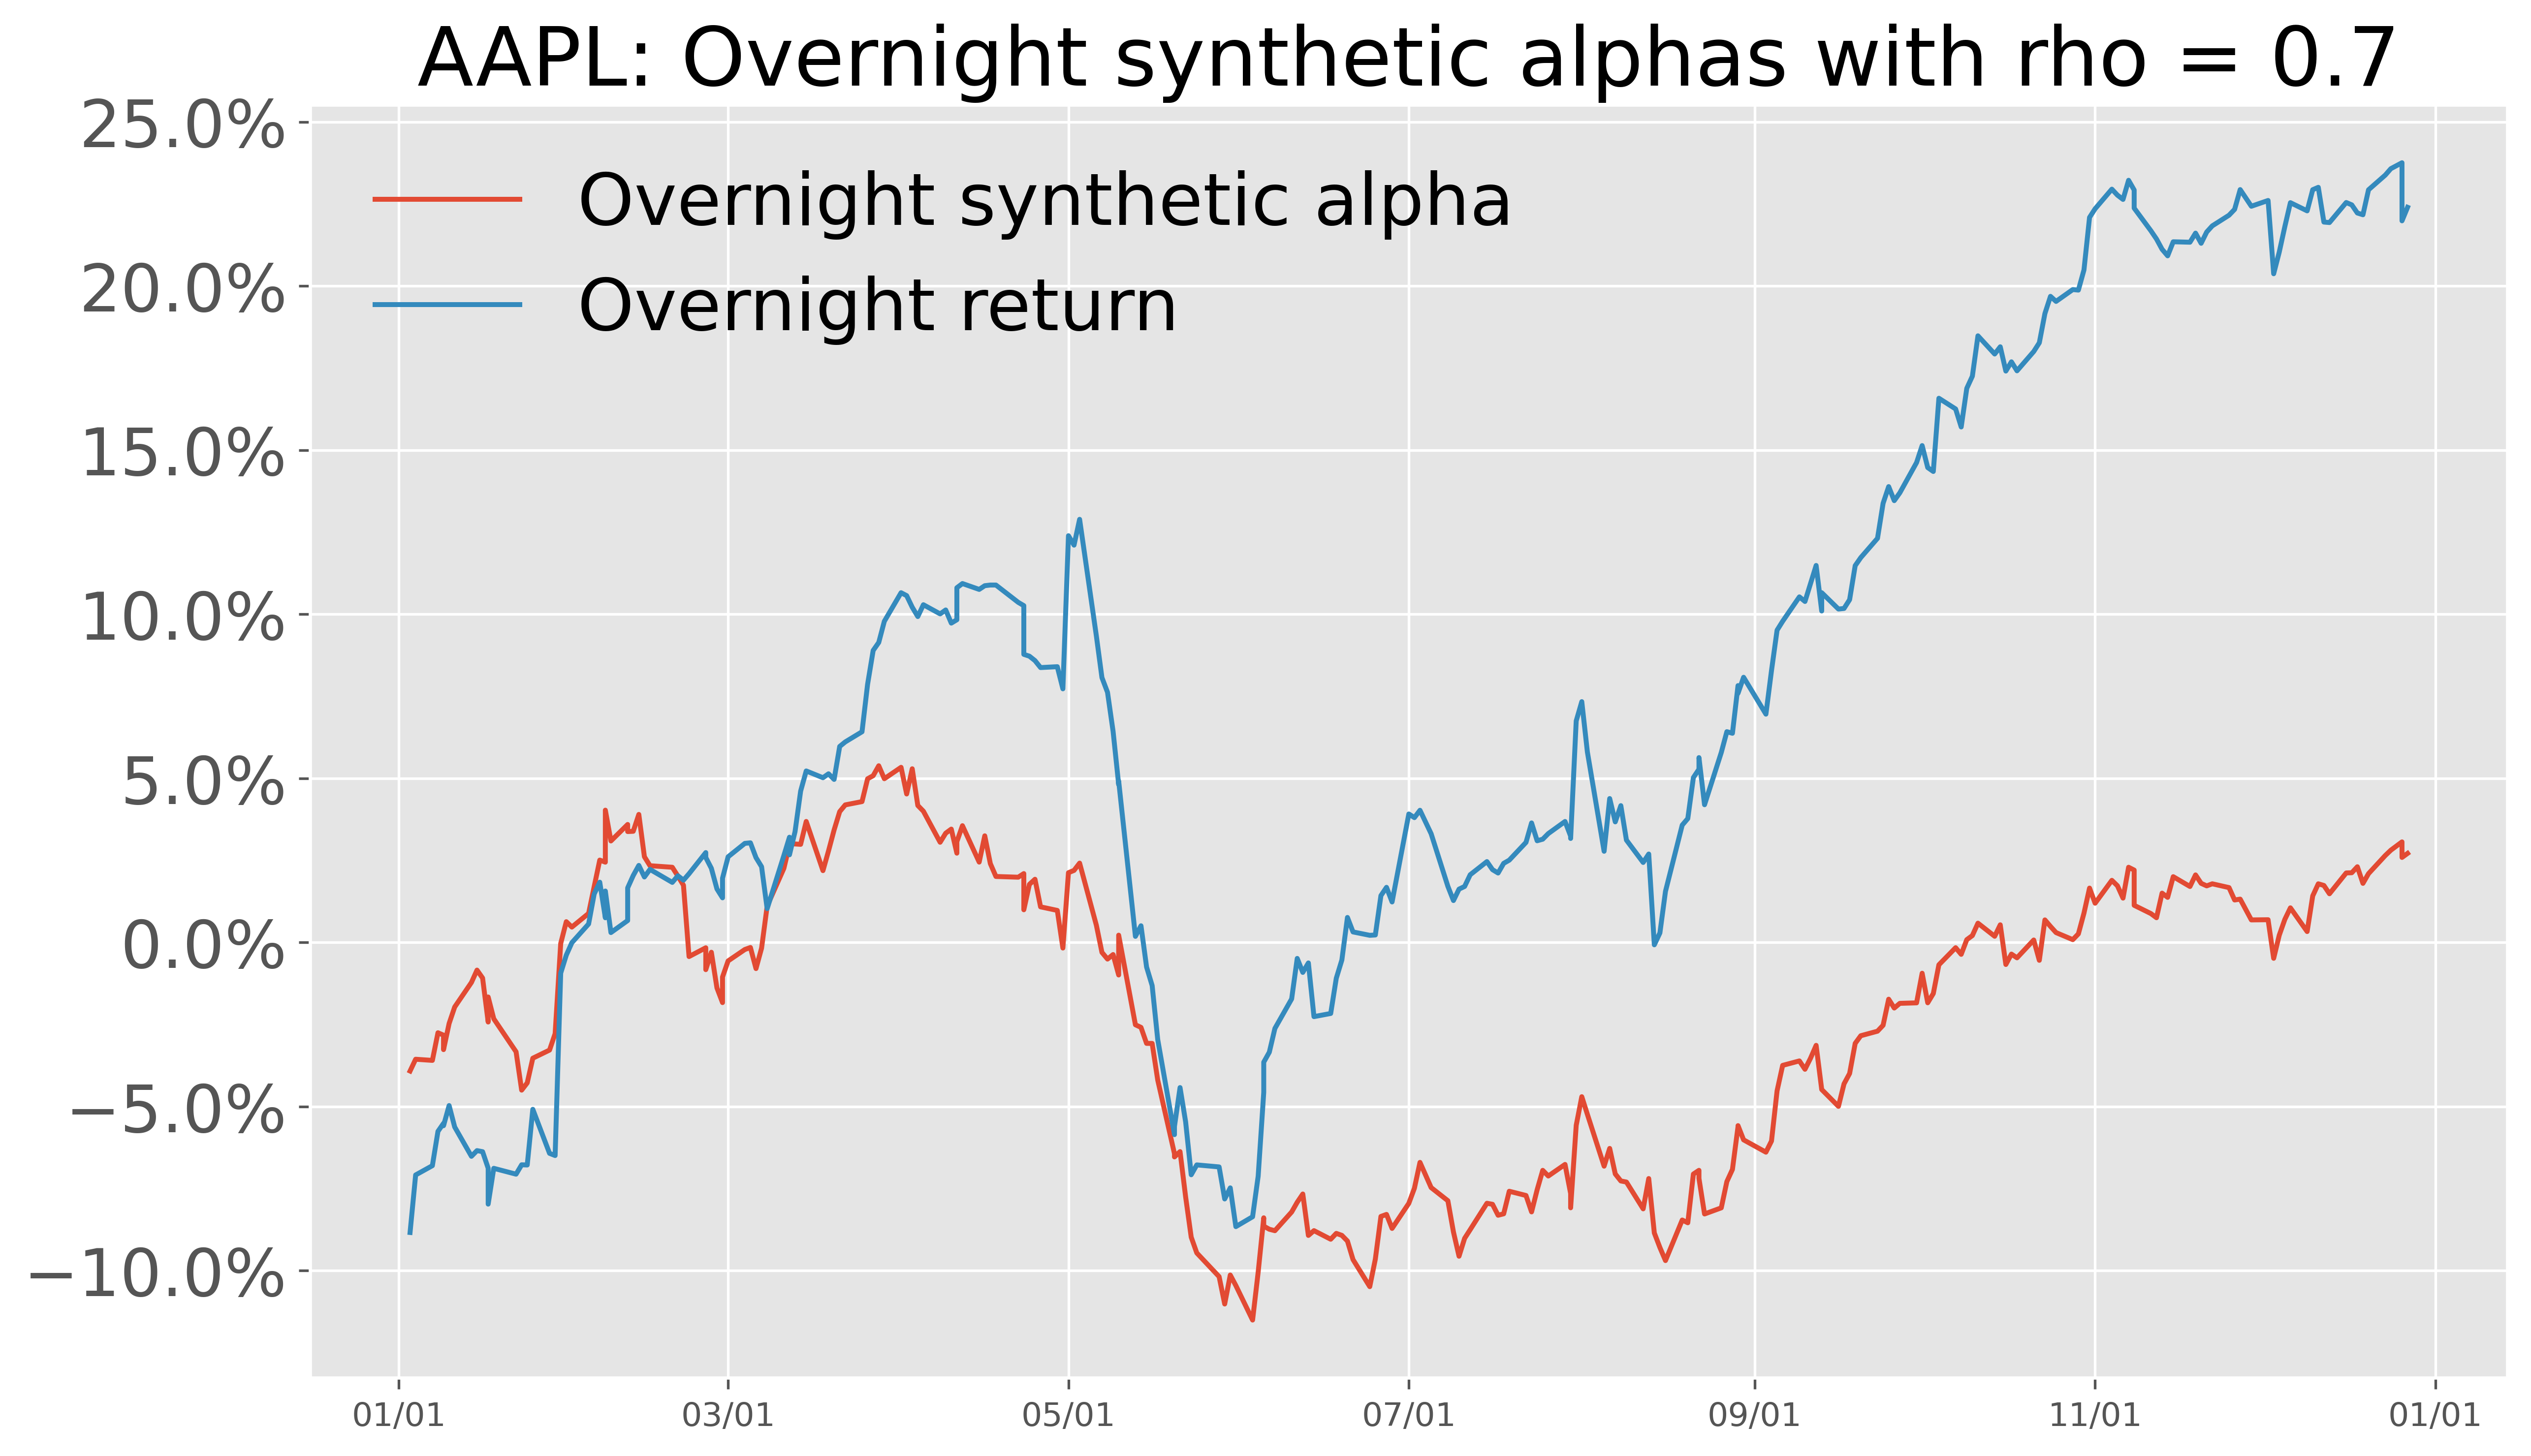

In [234]:
rho = 0.7
alpha_overnight, returns_overnight = synthetic_overnight_alpha_generator(rho, overnight_return_df, 1)

fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(pd.to_datetime(overnight_return_df["date"][1:]), alpha_overnight[1:].values.cumsum(), label="Overnight synthetic alpha")
ax.plot(pd.to_datetime(overnight_return_df["date"][1:]), returns_overnight[1:].values.cumsum(), label="Overnight return")
ax.legend(fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title(f"AAPL: Overnight synthetic alphas with rho = {rho}", fontsize=25)
xfmt = mdates.DateFormatter('%m/%d')
plt.gca().xaxis.set_major_formatter(xfmt)
ax.legend(fontsize=22, frameon=False)
plt.savefig('on_syn_alpha.eps', format='eps')
plt.show()

# 2.5. Optimal trading strategy
Implement trading strategies based on the alpha signal.

## 2.5.1 Baseline: implements the optimal strategy for the OW model and the fitted model

For OW model:
$$
I_t = \frac{1}{2} \alpha_t - \beta^{-1} \alpha_t'
$$
where $\alpha_t'$ is the first derivative of $\alpha_t$ against $\Delta t$.

The corresponding trading strategy $Q_t$ satisfies:
$$
dQ_t = \frac{\beta}{2\lambda} (\alpha_t - \beta^{-2} \alpha_t'')\,dt
$$

For reduced model:

$$
I_t = \frac{1}{2} (\alpha_t - \beta^{-1} \mu_t)
$$

$$
\Delta_t Q = \frac{1}{\lambda_t} (\beta I_t \delta t + \Delta_t I)
$$

where $v_t = \sum_{s=t-\Delta t}^t |q_s|$ and $\lambda_t = \frac{\lambda}{\sqrt{v_t}}$.

In [235]:
def optimal_trade(alpha, half_life, px_vol, ADV, impact_coef, time_unit = 10, model = "OW"):
    beta = np.log(2)/half_life
    decay_factor = np.exp(-beta * time_unit)
    if model == "Reduced":
        pass
    elif model == "OW":
        smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)
        optimal_impact = 0.5 * (smoothed - deriv_1 / beta)
        optimal_impact.iloc[-1] = smoothed.iloc[-1]
        optimal_trades = beta * (smoothed - deriv_2/ (beta ** 2 )) / (px_vol.values / ADV.values * impact_coef) / 2 * time_unit
        optimal_trades.iloc[0] = optimal_impact.iloc[0] / (px_vol / ADV * impact_coef) # I_0^* / lambda
        optimal_trades.iloc[-1] += (smoothed.iloc[-1] - optimal_impact.iloc[-2] * decay_factor) / (px_vol.values / ADV.values * impact_coef)
        
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV.values
        total_trade_sizes = abs(pct_synthetic_alpha_optimal_trades).sum() # if df then axis = 1
        
        return optimal_trades,optimal_impact,pct_synthetic_alpha_optimal_trades, total_trade_sizes

In [243]:
asset = "AAPL"
dates = "2019-03-14"
rho = 0.1
alpha,returns = synthetic_alpha(rho, asset, dates)
alpha = alpha.cumsum()
returns = returns.cumsum()

smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)

opt_trades, opt_impact, volume_pct,sizes = optimal_trade(alpha, 3600, price_vol, ADV, res_ow["beta_estimate"], time_unit = 10, model = "OW")

C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4748496.00680968  -3336008.19747074   -763169.71075067 ...
   4737578.72893109 -36989297.06377441         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay)
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_returns = prices / prices[0] - 1
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\1169919296.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(opt_impact.index), opt_impact.values, label="Optimal trade impact")
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\1169919296.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(smoothed.index), smoothed.values, label="Smoothed synthetic alpha")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


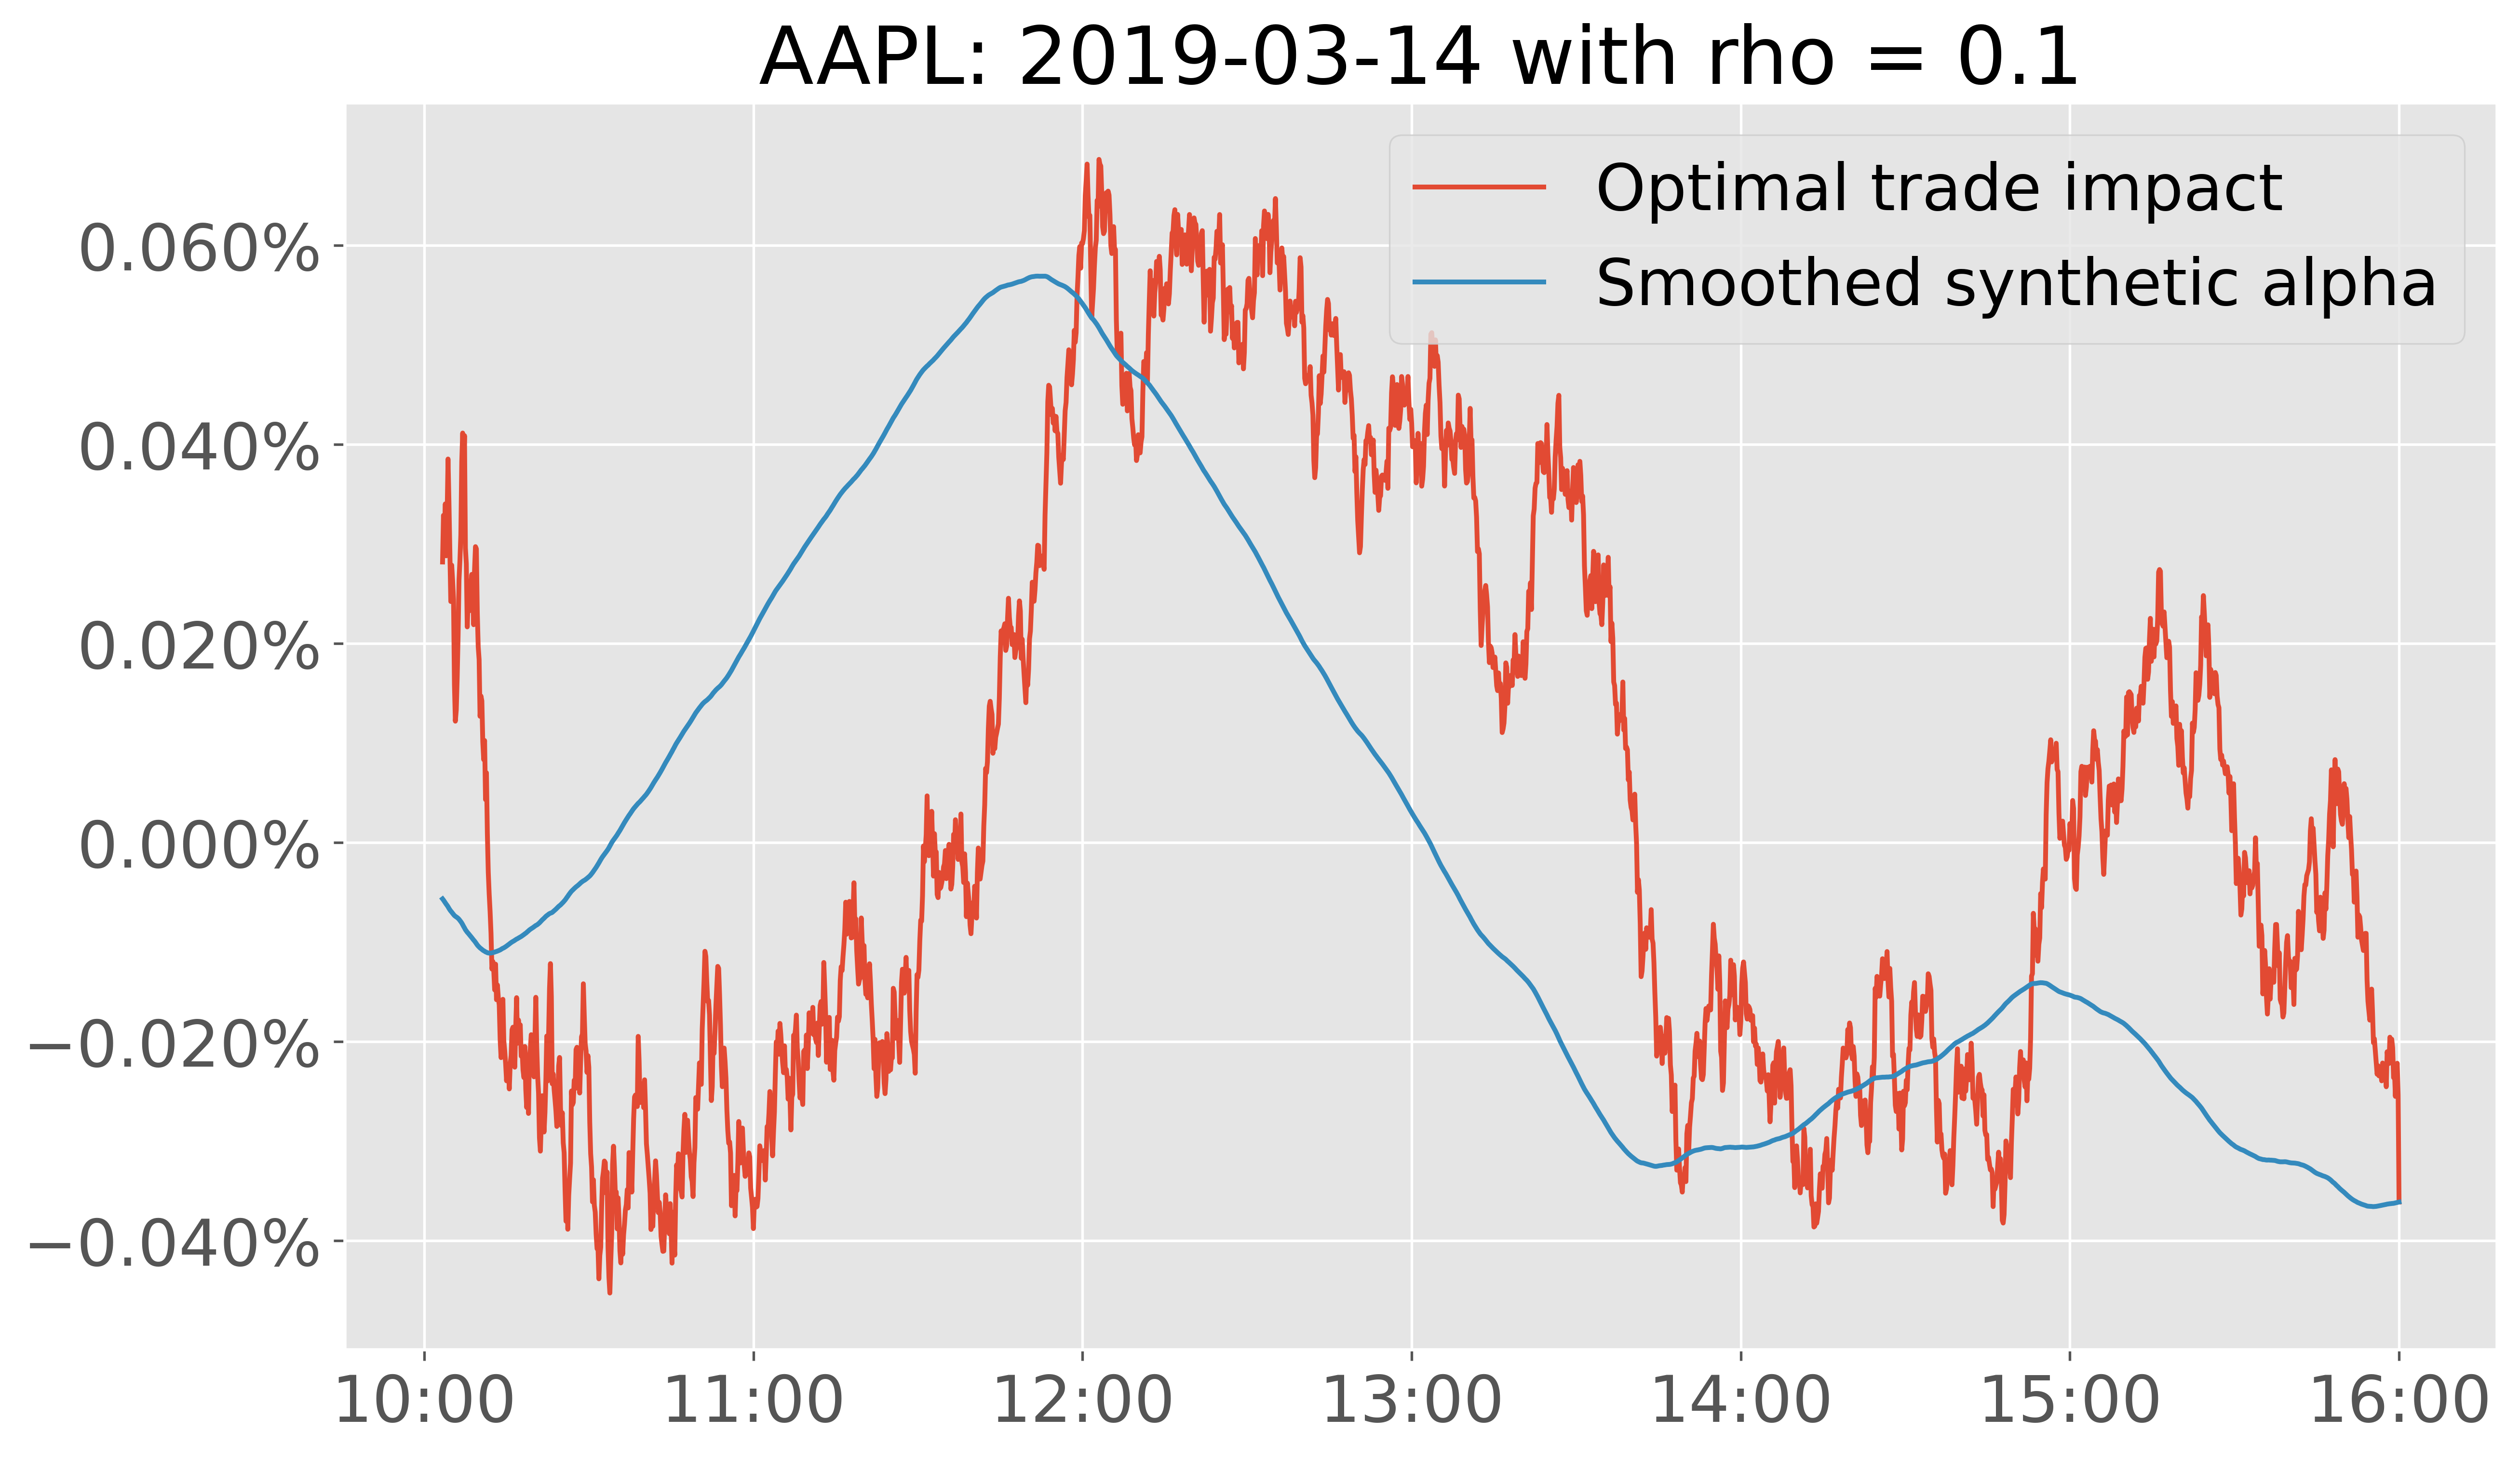

In [244]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(pd.to_datetime(opt_impact.index), opt_impact.values, label="Optimal trade impact")
ax.plot(pd.to_datetime(smoothed.index), smoothed.values, label="Smoothed synthetic alpha")
ax.legend(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

ax.set_title(f"{asset}: {dates} with rho = {rho}", fontsize=25)     # Replace with your actual plot title
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.savefig('impact_smth_syn_alpha.eps', format='eps')
plt.show()

In [245]:
asset = "AAPL"
dates = "2019-03-14"
rho = 0.1
alpha,returns = synthetic_alpha(rho, asset, dates)
alpha = alpha.cumsum()
returns = returns.cumsum()

smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)

opt_trades, opt_impact, volume_pct,sizes = optimal_trade(alpha, 3600, price_vol, ADV, res_ow["beta_estimate"], time_unit = 10, model = "OW")

res_2 = impact_resultant_prices(opt_trades, S[200:], decay, res_ow["beta_estimate"], "OW", price_vol.values, ADV.values)
df = pd.DataFrame({'observed price': prices, 'S-resultant price': res_2, 'unperturbed price S': S[200:]})

C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4748496.00680968  -3336008.19747074   -763169.71075067 ...
   4737578.72893109 -36989297.06377441         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay)
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cum_returns = prices / prices[0] - 1
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\4150863844.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\2664938699.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(df.index), df['S-resultant price'], label='S-resultant price')
C:\Users\Yuning LI\AppData\Local\Temp\ipykernel_17524\2664938699.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ax.plot(pd.to_datetime(df.index), df['unperturbed price S'], label="unperturbed price S")
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


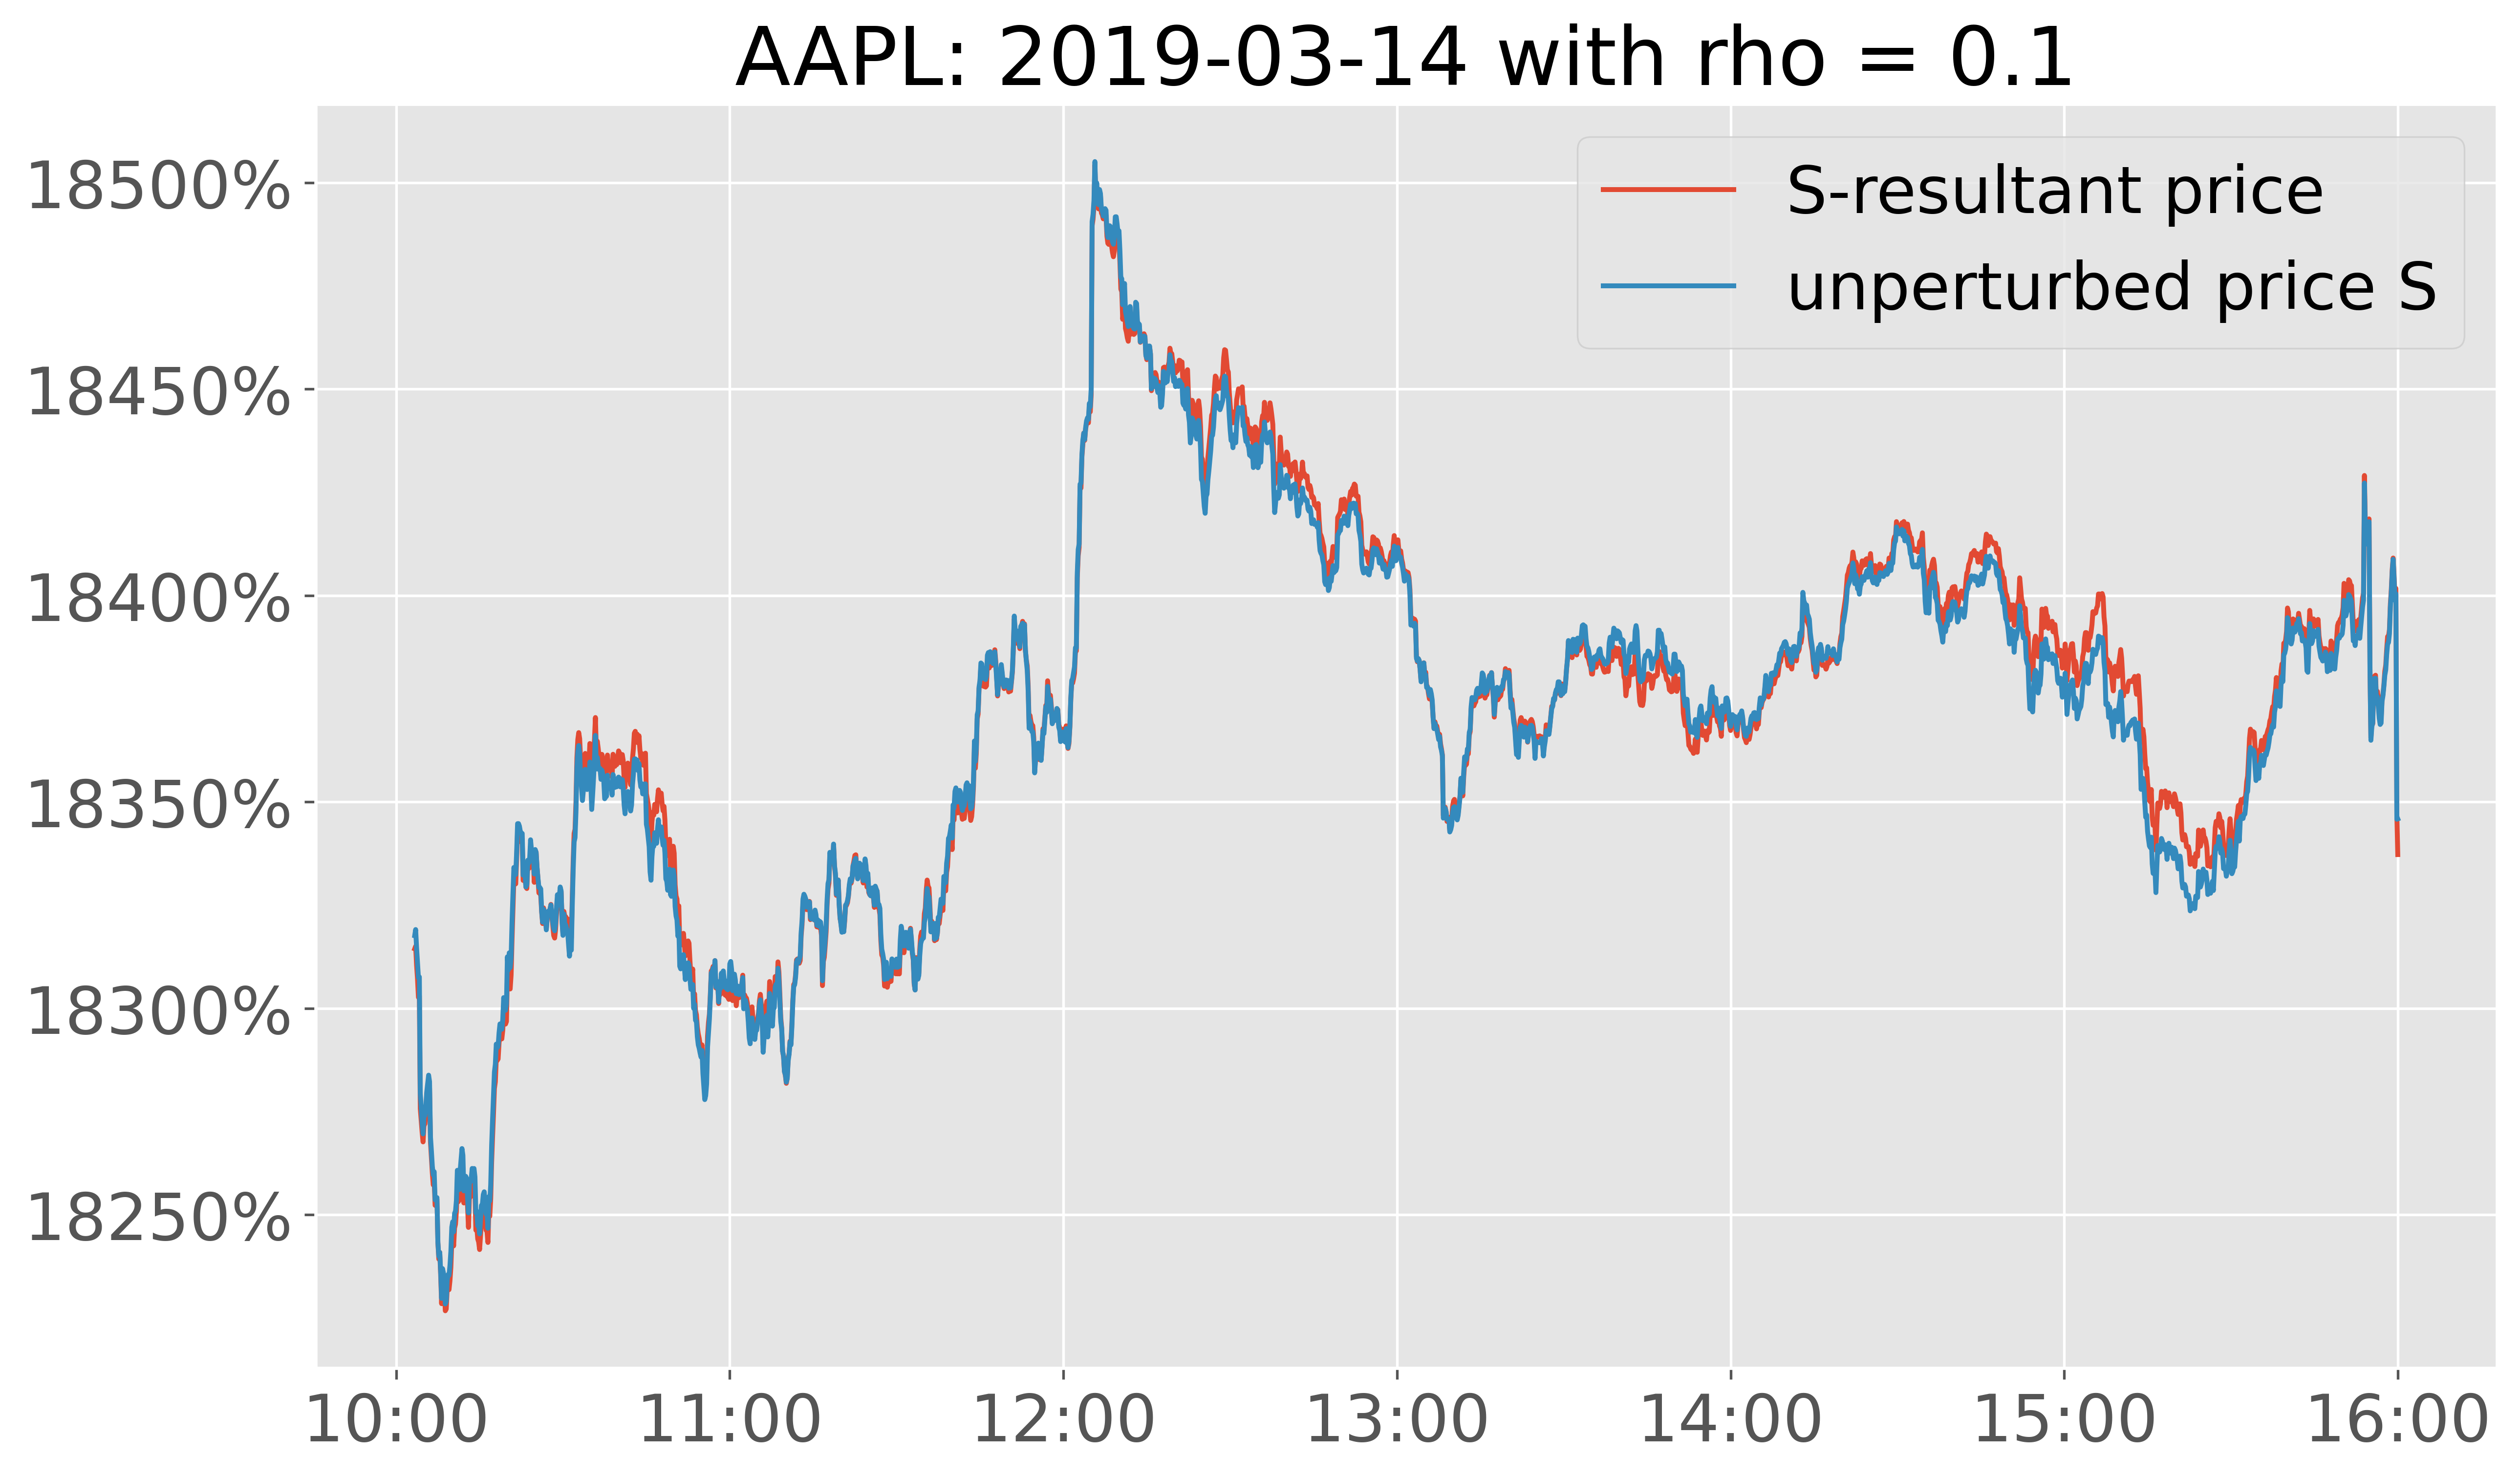

In [246]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)

ax.plot(pd.to_datetime(df.index), df['S-resultant price'], label='S-resultant price')
ax.plot(pd.to_datetime(df.index), df['unperturbed price S'], label="unperturbed price S")

ax.legend(fontsize=20)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title(f"{asset}: {dates} with rho = {rho}", fontsize=25)     # Replace with your actual plot title
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
xfmt = mdates.DateFormatter('%H:%M')
plt.gca().xaxis.set_major_formatter(xfmt)
plt.savefig('syn_alpha_adjusted_price.eps', format='eps')
plt.show()